## 기본설정 및 함수정의

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
from keplergl import KeplerGl

# tqdm의 pandas전용 메소드를 호출
tqdm.pandas()
# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)
 
# Point를만드는 함수
def make_point(x):
    try:
        return Point(x)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])
    
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.progress_apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

##### 행정동

In [2]:
# 하남시 행정동 데이터
shapefile_path1 = "SBJ_2411_001/bnd_dong_31180_2023_2Q/bnd_dong_31180_2023_2Q.shp"
hanam_gdf = gpd.read_file(shapefile_path1)
hanam_gdf = hanam_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 화성시 행정동 데이터
shapefile_path2 = "SBJ_2411_001/bnd_dong_31240_2023_2Q/bnd_dong_31240_2023_2Q.shp"
hwasung_gdf = gpd.read_file(shapefile_path2)
hwasung_gdf = hwasung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

#### 격자

In [3]:
# GeoJSON 파일 불러오기
with open('SBJ_2411_001/2-14.하남시_격자.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df = pd.json_normalize(geojson_data['features'])
grid_map_df['geometry'] = grid_map_df['geometry.coordinates'].apply(lambda x : make_pol(x))
grid_map_df.drop(columns="geometry.coordinates", axis=1, inplace=True)
grid_map_df = grid_map_df[~grid_map_df['properties.gid'].str.startswith('다아')]
# grid_map_df 데이터프레임을 GeoDataFrame으로 변환
grid_map_df = gpd.GeoDataFrame(grid_map_df, geometry='geometry')
grid_dict = dict(zip(grid_map_df['properties.gid'], grid_map_df['geometry']))

#### 공유차량 이용현황

In [4]:
sharecar_df = pd.read_csv('SBJ_2411_001/2-11.하남시_공유차량_이용현황.csv')
cols_to_exclude = ['car_type', 'car_cnt', 'car_type']  # 제외할 열
columns_to_fill = [col for col in sharecar_df.columns if col not in cols_to_exclude]
sharecar_df[columns_to_fill] = sharecar_df[columns_to_fill].fillna(0)
sharecar_df['car_type'] = sharecar_df['car_type'].fillna("")

from sklearn.linear_model import LinearRegression

train_data = sharecar_df.dropna(subset=['car_cnt', 'total_cnt', 'total_tm'])  # 세 열 모두 값이 있는 데이터
test_data = sharecar_df[sharecar_df['car_cnt'].isna()]  # car_cnt가 결측인 데이터

X_train = train_data[['total_cnt', 'total_tm']]  # 독립 변수
y_train = train_data['car_cnt']  # 종속 변수

model = LinearRegression()
model.fit(X_train, y_train)

if not test_data.empty:
    X_test = test_data[['total_cnt', 'total_tm']]
    predicted_car_cnt = model.predict(X_test) 
    predicted_car_cnt = np.maximum(predicted_car_cnt, 1)
    sharecar_df.loc[test_data.index, 'car_cnt'] = predicted_car_cnt.astype(int)

for col in columns_to_fill:
    if sharecar_df[col].dtype in ['float64', 'int64']:
        sharecar_df[col] = sharecar_df[col].astype(int)
sharecar_df["car_cnt"] = sharecar_df["car_cnt"].astype(int)


last_two_cols = sharecar_df.columns[-2:].tolist()
new_columns = list(sharecar_df.columns)
new_columns = [col for col in new_columns if col not in last_two_cols] 
new_columns[2:2] = last_two_cols 
sharecar_df = sharecar_df[new_columns]

##### 공공주택 데이터와 병합

In [15]:
sharehouse_df = pd.read_csv('SBJ_2411_001/2-12.공공주택임대_정보(하남시).csv')

# 그룹화 및 처리 함수 정의
def process_matching_rows(group):
    # 첫 번째와 두 번째 열: 같은 값이므로 하나의 값 선택
    col1_value = group.iloc[0, 0]  # 첫 번째 열
    col2_value = group.iloc[0, 1]  # 두 번째 열

    # 세 번째 열: ','로 구분해 값 결합
    col3_combined = ",".join(group.iloc[:, 2].astype(str).unique())  # 세 번째 열

    # 네 번째와 다섯 번째 열: 숫자 합산
    col4_sum = group.iloc[:, 3].sum()  # 네 번째 열
    col5_sum = group.iloc[:, 4].sum()  # 다섯 번째 열

    # 여섯 번째와 일곱 번째 열: 같은 값이므로 하나의 값 선택
    col6_value = group.iloc[0, 5]  # 여섯 번째 열
    col7_value = group.iloc[0, 6]  # 일곱 번째 열

    return pd.Series([col1_value, col2_value, col3_combined, col4_sum, col5_sum, col6_value, col7_value])

# sharehouse_df를 blck_cd 기준으로 그룹화하고 처리
processed_sharehouse = (
    sharehouse_df.groupby("blck_cd").apply(process_matching_rows)
)

# 열 이름 재설정
processed_sharehouse.columns = [
    "col1_value", "col2_value", "col3_combined", "col4_sum", "col5_sum", "col6_value", "col7_value"
]

# sharecar_df와 병합
merged_df = pd.merge(sharecar_df, processed_sharehouse, on="blck_cd", how="left")
merged_df = merged_df.iloc[:,2:]
new_column_names = sharehouse_df.columns
merged_df.columns = list(merged_df.columns[:-7]) + list(new_column_names)
merged_df = geo_transform(merged_df)
last_8_columns = merged_df.columns[-8:]
remaining_columns = merged_df.columns[:-8]

merged_df = merged_df[list(last_8_columns) + list(remaining_columns)]
merged_df['parking_slot'] = merged_df['parking_slot'].fillna(0)
merged_df['parking_slot'] = merged_df['parking_slot'].astype(int)
merged_df = merged_df.drop(columns=['lon', 'lat'])
merged_gdf = merged_df.reset_index(drop=True)

grid_map_gdf = grid_map_df.reset_index(drop=True)
joined_gdf = gpd.sjoin(merged_df, grid_map_df, how='left', op='within')
joined_gdf['geometry'] = joined_gdf['properties.gid'].map(grid_dict)
target_column = joined_gdf.columns[-2]
columns = list(joined_gdf.columns)
columns.remove(target_column)
columns.insert(5, target_column)

joined_gdf = joined_gdf[columns]
joined_gdf = joined_gdf.iloc[:,:-3]
joined_gdf = joined_gdf.dropna(subset=['blck_cd'])
joined_gdf['noh'] = joined_gdf['noh'].astype(int)
joined_gdf['type_left'] = joined_gdf['type_left'].apply(lambda x : '+'.join(x.split(',')))
joined_gdf.rename(columns={'type_left':'type'}, inplace=True)
joined_gdf['type'] = joined_gdf['type'].apply(
    lambda x: '+'.join(sorted(x.split('+'))) if '+' in x else x
)

# 차량 활용 점수 (Vehicle Utilization Score, VUS) 계산코드드
joined_gdf['car_cnt'] = joined_gdf['car_cnt'].fillna(0).replace(0, 1)  # 0으로 나눔 방지
joined_gdf['total_cnt'] = joined_gdf['total_cnt'].fillna(0)
joined_gdf['total_tm'] = joined_gdf['total_tm'].fillna(0)

# 가중치 설정
w1, w2 = 0.5, 0.5  # 기본값: 건수와 시간을 동일한 비중으로 고려

# 차량 활용 점수 계산
joined_gdf['vehicle_utilization_score'] = (
    w1 * (joined_gdf['total_cnt'] / joined_gdf['car_cnt']) + 
    w2 * (joined_gdf['total_tm'] / joined_gdf['car_cnt'])
)

100%|██████████| 16/16 [00:00<00:00, 9829.92it/s]
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\user\AppData\Local\Temp\ipykerne

#### 상권 접근성

In [17]:
business_area_data = pd.read_csv('SBJ_2411_001/2-4.하남시_상권정보.csv')
business_area_data = business_area_data[business_area_data['std_year'] == 2024]
business_area_data = geo_transform(business_area_data)

from shapely.ops import transform

# Function to create a 300m buffer around each geometry
def create_buffer(geometry, distance=300):
    # Define the projection to work in meters (UTM)
    project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True).transform
    reverse_project = pyproj.Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True).transform
    buffer = transform(project, geometry).buffer(distance)  # Create buffer in meters
    return transform(reverse_project, buffer)

# Add buffer geometry for each housing location
joined_gdf['buffer_300m'] = joined_gdf['geometry'].apply(lambda geom: create_buffer(geom, distance=300))

# Count the number of businesses within 300m for each housing location
def count_businesses_within_buffer(housing_geometry, business_geometries):
    return business_geometries.apply(lambda geom: housing_geometry.contains(geom)).sum()

# Ensure business_area_data['geometry'] is properly loaded
joined_gdf['business_count_within_300m'] = joined_gdf['buffer_300m'].apply(
    lambda buffer: count_businesses_within_buffer(buffer, business_area_data['geometry'])
)

# Drop the buffer column if not needed for further analysis
joined_gdf.drop(columns=['buffer_300m'], inplace=True)

100%|██████████| 15794/15794 [00:00<00:00, 27568.36it/s]
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 공공주택 임대료

In [18]:
sharehouse_cost_df = pd.read_csv('SBJ_2411_001/2-13.공공주택임대_임대료(하남시).csv')
mean_rental_price = sharehouse_cost_df.groupby('blck_cd')['pay_rent'].mean().reset_index()
joined_gdf = pd.merge(joined_gdf, mean_rental_price, on='blck_cd', how='left')
joined_gdf['pay_rent'] = joined_gdf['pay_rent'].astype(int)

#### 지역적 특성 상관관계 분석

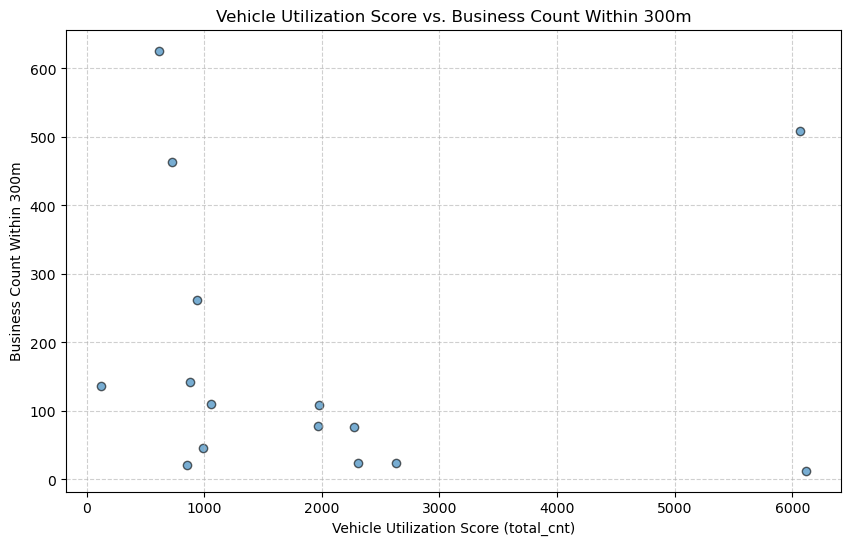

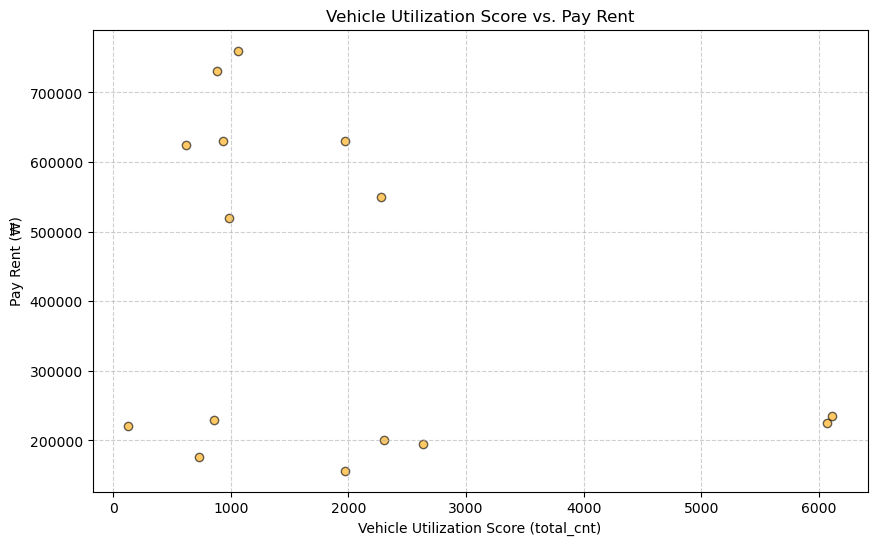

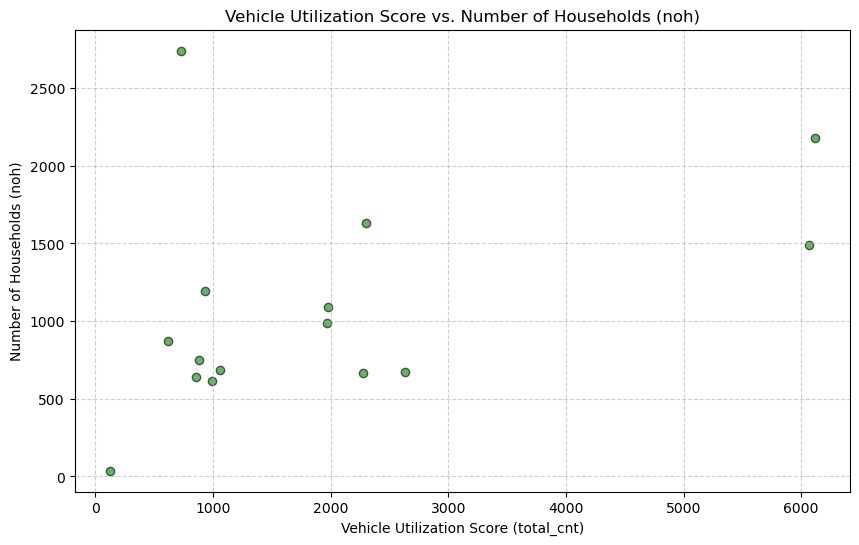

In [19]:
import matplotlib.pyplot as plt
# Scatter plot for vehicle_utilization_score vs. business_count_within_300m
plt.figure(figsize=(10, 6))
plt.scatter(joined_gdf['total_cnt'], joined_gdf['business_count_within_300m'], alpha=0.6, edgecolors='k')
plt.title('Vehicle Utilization Score vs. Business Count Within 300m')
plt.xlabel('Vehicle Utilization Score (total_cnt)')
plt.ylabel('Business Count Within 300m')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Scatter plot for vehicle_utilization_score vs. pay_rent
plt.figure(figsize=(10, 6))
plt.scatter(joined_gdf['total_cnt'], joined_gdf['pay_rent'], alpha=0.6, edgecolors='k', color='orange')
plt.title('Vehicle Utilization Score vs. Pay Rent')
plt.xlabel('Vehicle Utilization Score (total_cnt)')
plt.ylabel('Pay Rent (₩)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Scatter plot for vehicle_utilization_score vs. noh (number of households)
plt.figure(figsize=(10, 6))
plt.scatter(joined_gdf['total_cnt'], joined_gdf['noh'], alpha=0.6, edgecolors='k', color='green')
plt.title('Vehicle Utilization Score vs. Number of Households (noh)')
plt.xlabel('Vehicle Utilization Score (total_cnt)')
plt.ylabel('Number of Households (noh)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


#### 모델 학습 준비

In [33]:
property2_df = joined_gdf[['blck_cd', 'type', 'noh', 'total_cnt', 'total_tm', 'car_cnt', 'vehicle_utilization_score', 'business_count_within_300m', 'pay_rent']]

In [34]:
property2_df.to_csv('property2_df.csv', index=False)

#### 교산지구 데이터

In [24]:
from shapely.wkt import loads

# Convert WKT strings to shapely geometry
sh_ob_sup = pd.read_csv('sh_ob_sup.csv')
sh_ob_sup['geometry'] = sh_ob_sup['geometry'].apply(loads)
sh_ob_sup = gpd.GeoDataFrame(sh_ob_sup, geometry='geometry')

In [25]:
business_area_data = pd.read_csv('SBJ_2411_001/2-4.하남시_상권정보.csv')
business_area_data = business_area_data[business_area_data['std_year'] == 2024]
business_area_data = geo_transform(business_area_data)

from shapely.ops import transform

# Function to create a 300m buffer around each geometry
def create_buffer(geometry, distance=300):
    # Define the projection to work in meters (UTM)
    project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True).transform
    reverse_project = pyproj.Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True).transform
    buffer = transform(project, geometry).buffer(distance)  # Create buffer in meters
    return transform(reverse_project, buffer)

# Add buffer geometry for each housing location
sh_ob_sup['buffer_300m'] = sh_ob_sup['geometry'].apply(lambda geom: create_buffer(geom, distance=300))

# Count the number of businesses within 300m for each housing location
def count_businesses_within_buffer(housing_geometry, business_geometries):
    return business_geometries.apply(lambda geom: housing_geometry.contains(geom)).sum()

# Ensure business_area_data['geometry'] is properly loaded
sh_ob_sup['business_count_within_300m'] = sh_ob_sup['buffer_300m'].apply(
    lambda buffer: count_businesses_within_buffer(buffer, business_area_data['geometry'])
)

# Drop the buffer column if not needed for further analysis
sh_ob_sup.drop(columns=['buffer_300m'], inplace=True)

100%|██████████| 15794/15794 [00:00<00:00, 28551.27it/s]
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [28]:
property_new_df = sh_ob_sup[['blockname', 'type', 'noh', 'total_cnt', 'total_tm', 'business_count_within_300m']]

In [32]:
property_new_df

,blockname,type,noh,total_cnt,total_tm,business_count_within_300m
0,A-1,통합공공임대,823,1663.273114,5587.135208,84
1,A-1,통합공공임대,823,1663.273114,5587.135208,84
2,A-3,행복주택,394,1161.432585,3898.416378,29
3,A-4,통합공공임대,808,1645.726242,5528.089095,142
4,A-6,행복주택,769,1600.104376,5374.569201,50
5,A-7,통합공공임대,1605,2578.050023,8665.405895,38
6,A-9,통합공공임대,525,1314.675264,4414.085764,46
7,A-10,통합공공임대,491,1274.902355,4280.247908,33
8,A-11,행복주택,715,1536.935638,5162.003195,37
9,A-12,통합공공임대,807,1644.556451,5524.152687,21


In [31]:
property_new_df.to_csv('property2_new_df.csv', index=False)